[View in Colaboratory](https://colab.research.google.com/github/AnujArora23/FlightDelayML/blob/master/DTFlightDelayDataset.ipynb)

# Flight Delay Prediction (Regression)

**NOTE: THIS IS A CONTINUATION OF THE  *SGDFlightDelayDataset.ipynb*  NOTEBOOK WHICH USES  STOCHASTIC GRADIENT DESCENT REGRESSION. THIS PART ONLY CONTAINS THE BOOSTED DECISION TREE PREDICTION AND COMPARISON BETWEEN THE TWO. FOR DATA CLEANING AND EXPLORATION, PLEASE SEE THE PREVIOUS NOTEBOOK.**

These datasets are taken from Microsoft Azure Machine Learning Studio's sample datasets. It contains flight delay data for various airlines for the year 2013. There are two files uploaded as a compressed archive on my GitHub page:

1) **Flight_Delays_Data.csv** : This contains arrival and departure details for various flights operated by 16 different airlines. The schema is pretty self explanatory but I will mention the important and slightly obscure columns:

*OriginAirportID/DestAirportID* : The unique 5 digit integer identifier for a particular airport.

*CRSDepTime/CRSArrTime* : Time in 24 hour format (e.g. 837 is 08:37AM)

*ArrDel15/DepDel15* : Binary columns where *1* means that the flight was delayed beyond 15 minutes and *0* means it was not.

*ArrDelay/DepDelay* : Time (in minutes) by which flight was delayed.


2) **Airport_Codes_Dataset.csv** : This file gives the city, state and name of the airport along with the unique 5 digit integer identifier.

### Goals:


**1.  Clean the data, and see which features may be important and which might be redundant.**

**2. Do an exploratory analysis of the data to identify where most of the flight delays lie (e.g. which carrier, airport etc.).**

**3.  Choose and build an appropriate regression model for this dataset to predict *ArrDelay* time in minutes.**

**4. Choose and build alternative models and compare all models with various accuracy metrics.**



## Install and import necessary libraries

In [0]:
!pip install -U -q PyDrive #Only if you are loading your data from Google Drive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search
from sklearn import metrics

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Authorize Google Drive (if your data is stored in Drive)

In [3]:
%%capture
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline

Enter verification code: ··········


## Data Ingestion

I have saved the two files in my personal drive storage and read them from there into a pandas data frame. Please modify the following cells to read the CSV files into a Pandas dataframe as per your storage location.

In [0]:
%%capture
downloaded = drive.CreateFile({'id':'1VxxZFZO7copAM_AHHF42zjO7rlGR1aPm'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Airport_Codes_Dataset.csv')  
downloaded = drive.CreateFile({'id':'1owzv86uWVRace_8xvRShFrDTRXSljp3I'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Flight_Delays_Data.csv') 
airpcode = pd.read_csv('Airport_Codes_Dataset.csv') 
flightdel = pd.read_csv('Flight_Delays_Data.csv') 

## Data Cleanup

### Remove NULL /NaN rows and drop redundant columns

In [0]:
flightdel.dropna(inplace=True) #Drop NaNs. We will still have enough data
flightdel.drop(['Year','Cancelled'],axis=1,inplace=True) #There is only 1 unique value for both (2013 and 0 respectively)
flightdel.reset_index(drop=True,inplace=True)

###Join the 2 CSV files to get airport code details for origin and destination

In [0]:
result=pd.merge(flightdel,airpcode,left_on='OriginAirportID',right_on='airport_id',how='left')
result.drop(['airport_id'],axis=1,inplace=True)
#result.reset_index(drop=True,inplace=True)
result.rename(columns={'city':'cityor','state':'stateor','name':'nameor'},inplace=True)
result=pd.merge(result,airpcode,left_on='DestAirportID',right_on='airport_id',how='left')
result.drop(['airport_id'],axis=1,inplace=True)
result.reset_index(drop=True,inplace=True)
result.rename(columns={'city':'citydest','state':'statedest','name':'namedest'},inplace=True)
flightdelfin=result

### Perform Feature Conversion (to categorical dtype)

In [0]:
cols=['Carrier','DepDel15','ArrDel15','OriginAirportID','DestAirportID','cityor','stateor','nameor','citydest','statedest','namedest']
flightdelfin[cols]=flightdelfin[cols].apply(lambda x: x.astype('category'))     

###Drop duplicate observations

In [0]:
flightdelfin.drop_duplicates(keep='first',inplace=True)
flightdelfin.reset_index(drop=True,inplace=True)

###Drop columns that are unnecessary for analysis

**In particular, we drop ArrDel15 and DepDel15 columns as they add no extra information from the ArrDel and DepDel columns respectively.**

In [9]:
flightdelan=flightdelfin.iloc[:,0:11]
flightdelan.drop('DepDel15',axis=1,inplace=True)
flightdelan.head()

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,4,19,5,DL,11433,13303,837,-3.0,1138,1.0
1,4,19,5,DL,14869,12478,1705,0.0,2336,-8.0
2,4,19,5,DL,14057,14869,600,-4.0,851,-15.0
3,4,19,5,DL,15016,11433,1630,28.0,1903,24.0
4,4,19,5,DL,11193,12892,1615,-6.0,1805,-11.0


###Final check before analysis

** We check if our data types are correct and do a general scan of the dataframe information. It looks good! Everything is as it should be.**

In [10]:
flightdelan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690385 entries, 0 to 2690384
Data columns (total 10 columns):
Month              int64
DayofMonth         int64
DayOfWeek          int64
Carrier            category
OriginAirportID    category
DestAirportID      category
CRSDepTime         int64
DepDelay           float64
CRSArrTime         int64
ArrDelay           float64
dtypes: category(3), float64(2), int64(5)
memory usage: 151.4 MB


In [0]:
#flightdelan[['Month','DayofMonth','DayOfWeek']]=flightdelan[['Month','DayofMonth','DayOfWeek']].apply(lambda x: x.astype(np.int64))

## Prediction

### Convert Categorical Variables to Indicator Variables

**To do any sort of prediction, we need to convert the categorical variables to dummy (indicator) variables and drop one group in for each categorical column in the original table, so as to get a baseline to compare to. If we do not drop one group from each categorical variable, our regression will fail due to multicollinearity.**

**The choice of which group(s) to drop is complete arbitrary but in our case, we will drop the carrier with the least number of flights i.e. Hawaiian Airlines (HA), and we will choose an arbitrary city pair with just 1 flight frequency to drop. As of now I have chosen the OriginAirportID as 14771	and the DestAirportID as 13871 to be dropped.**


In [11]:
flightdeldum=pd.get_dummies(flightdelan)
flightdeldum.drop(['Carrier_HA','OriginAirportID_14771','DestAirportID_13871'],axis=1,inplace=True)
flightdeldum.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Carrier_9E,Carrier_AA,Carrier_AS,...,DestAirportID_14747,DestAirportID_14771,DestAirportID_14831,DestAirportID_14843,DestAirportID_14869,DestAirportID_14893,DestAirportID_14908,DestAirportID_15016,DestAirportID_15304,DestAirportID_15376
0,4,19,5,837,-3.0,1138,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,19,5,1705,0.0,2336,-8.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,19,5,600,-4.0,851,-15.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,19,5,1630,28.0,1903,24.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,19,5,1615,-6.0,1805,-11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**As one can see above, each cateogrical column has been converted to 'n' binary columns where n was the number of groups in that particular categorical column.  For example, the carrier column has been split into 16  indicator columns (number of unique carriers) and one has been dropped ('Carrier_HA').**

**Similar logic can be applied to the DestAirportID and OriginAirportID categorical columns.**

**NOTE: The Month, DayofMonth and DayofWeek columns have not been converted to indicator variables because they are ORDINAL cateogorical variables and not nominal. There is a need to retain their ordering because the 2nd month comes after the 1st and so on. Hence, since their current form retains their natural ordering, we do not need to touch these columns.**

### Decision Tree Regression

**To predict the arrival delays for various combinations of the input variables and future unseen data, we need to perform a regression since the output variable (ArrDelay) is a continuous one.**

**Decision trees are an alternative algorithm for prediction (both classification and regression). SGD regression, is after all, a form of multiple linear regression, which assumes linearity between features, whereas decision trees do not assume linearity between features. Hence, it is a good idea to run a decision tree regressor on our data set to see if we get any imporvement.**

In [0]:
scaler = preprocessing.StandardScaler()
flightdeldum[['CRSDepTime','CRSArrTime','DepDelay']]=scaler.fit_transform(flightdeldum[['CRSDepTime','CRSArrTime','DepDelay']])
y=flightdeldum.ArrDelay
X=flightdeldum.drop('ArrDelay',axis=1)

**In the cell above, we have scaled the relevant columns (Z score) that had values that were dissimilar to the rest of the features, as the regularization strategy we are going to use, requires features to be in a similar range.**

**We now split the data into training and testing data and in this case, we are going to use 80% of the data for training and the remaining for testing.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

**We use the min_samples_split parameter in the sklearn decision tree package, as a stopping criteria. **

In [14]:
# Fit regression model
regr_1 = DecisionTreeRegressor(min_samples_split=100)
regr_1.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

**In the above cell, we trained the model using the DecisionTreeRegressor and now it is time to predict using the test data.**

In [0]:
y_pred=regr_1.predict(X_test)

In [16]:
# The coefficients
#print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.values, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.values, y_pred))

Mean squared error: 184.26
Variance score: 0.88


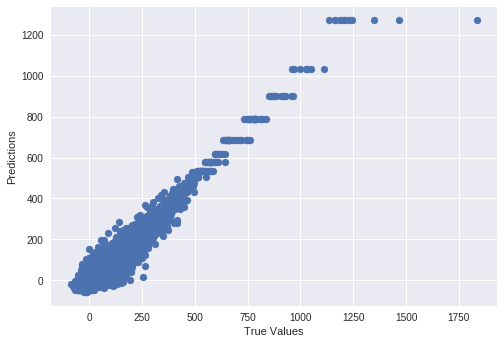

In [17]:
plt.scatter(y_test.values, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

**As we can see from the above cells, 88% of the variance (R^2 score) in the data has been captured and the model is predicting well. The trend line in the graph would be very close to the ideal 45 degree trend line (expected line if the model predicted with 100% accuracy).**

**However, we do not want to overfit our model because we want it to perform well on new untested data. To check if our model overfits, we can run a 6 fold cross validation and analyze the variance (R^2 scores) on each fold ,as shown below.**

In [20]:
# Perform 6-fold cross validation
kfold = KFold(n_splits=6)
scores = cross_val_score(regr_1, X, y, cv=kfold)
print 'Cross-validated scores:', scores
print 'Average Cross-validated score:', np.mean(scores)

Cross-validated scores: [0.86577284 0.86731056 0.88698003 0.86351271 0.85092398 0.8072933 ]
Average Cross-validated score: 0.8569655697586188


###Grid Search (Hyperparameter Tuning) (Optional and Computationally Expensive)

**The following function performs a search over the entire parameter grid (as specified below) for the minimum number of samples to split (minimum number of observations required for node to be split), and returns the optimal parameters, after an n fold cross validation.**

In [0]:
#https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
def dectree_param_selection(X, y, nfolds):
    min_samples_splits = [60,80,100]
    param_grid = {'min_samples_split': min_samples_splits}
    grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [23]:
dectree_param_selection(X_train,y_train,5)

{'min_samples_split': 100}

**As we can see above, the grid search has yielded the optimal parameters for the min_samples_split parameter. This process took about 40 minutes to execute as it is very computationally expensive.**

**Since, we received the same parameter as our initial estimate, we can conclude our decision tree regressor here.**

##Comparison

**We have seen that, after running a 6 fold cross validation (to eliminate overfitting), we have the following results for each of the predictors:**

**1) SGD Regression (with gridsearch parameters) : MSE  = ~164, R^2=~89%**

**2) Decision Tree Regression: MSE= ~184, R^2=~86%**


**Since both results involve at least a 5 fold cross validation, we can be assured that the models are not overfit. Hence, given the above figures, we can clearly see that the Stochastic Gradient Descent Regression is a better algorithm for this problem.**

**FINAL CHOICE: Stochastic Gradient Descent Regression.**